In [0]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.impute import SimpleImputer
import mlflo
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

In [0]:
df = spark.read.option("header", True).option("nullValue", "NULL").csv('s3://columbia-gr5069-main/raw/results.csv')
df = df.dropna(subset=["laps", "rank"])
     

df.write.mode('overwrite').parquet('s3://yw4381-gr5069/processed/F1_results')
     

display(df)

In [0]:
%sql
CREATE TABLE f1_model1_predictions (
    race_id INT,
    driver_id INT,
    predicted_position FLOAT,
    actual_position INT,
    prediction_date TIMESTAMP
);

ALTER TABLE f1_model1_predictions SET TBLPROPERTIES (
    'delta.feature.allowColumnDefaults' = 'supported'
);
ALTER TABLE f1_model1_predictions ALTER COLUMN prediction_date SET DEFAULT CURRENT_TIMESTAMP;


In [0]:
%sql
CREATE TABLE f1_model2_predictions (
    race_id INT,
    driver_id INT,
    predicted_position FLOAT,
    actual_position INT,
    prediction_date TIMESTAMP
);

ALTER TABLE f1_model2_predictions SET TBLPROPERTIES (
    'delta.feature.allowColumnDefaults' = 'supported'
);
ALTER TABLE f1_model2_predictions ALTER COLUMN prediction_date SET DEFAULT CURRENT_TIMESTAMP;

In [0]:
# Load the data from S3
df = spark.read.option("header", True).option("nullValue", "NULL").csv('s3://columbia-gr5069-main/raw/results.csv')
df = df.dropna(subset=["laps", "rank"])

# Convert necessary columns to appropriate types
df = df.withColumn("position", df["position"].cast("int"))
df = df.withColumn("points", df["points"].cast("float"))
df = df.withColumn("laps", df["laps"].cast("int"))
df = df.withColumn("rank", df["rank"].cast("int"))
df = df.withColumn("grid", df["grid"].cast("int"))

# Feature engineering
df = df.withColumn("grid_position_diff", df["grid"] - df["position"])

# Split the data for training and testing
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Convert to pandas for scikit-learn
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()

# Select features and target
features = ["grid", "laps", "grid_position_diff"]
target = "position"

X_train = train_pd[features]
y_train = train_pd[target]
X_test = test_pd[features]
y_test = test_pd[target]


In [0]:
mlflow.set_tracking_uri("databricks")

experiment = mlflow.set_experiment("/Users/yw4381@columbia.edu/F1_Position_Prediction")


2025/04/27 19:42:36 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Linear Regression model metrics: RMSE=3.0265, MAE=2.5428, R2=0.3599


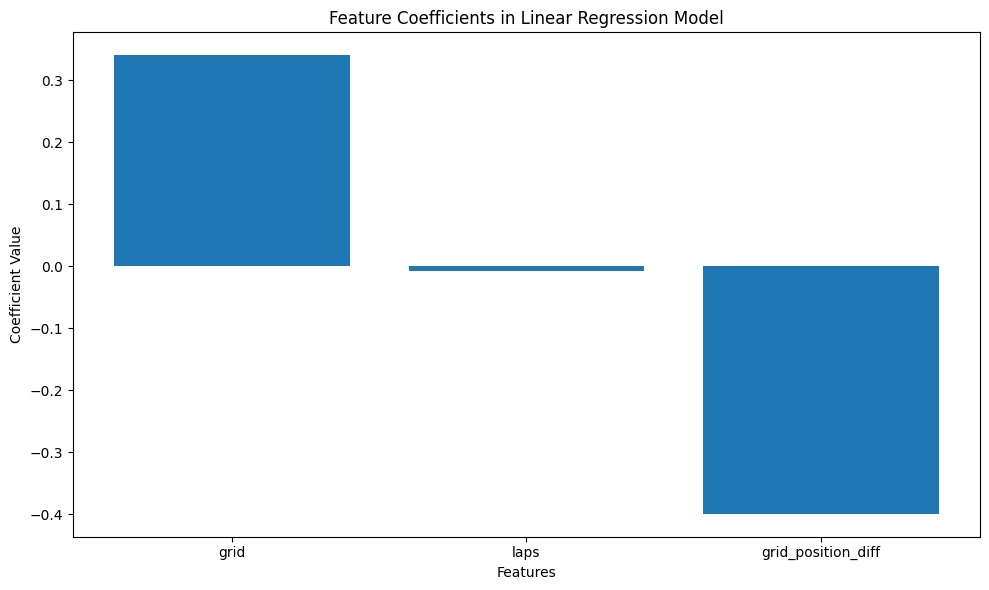

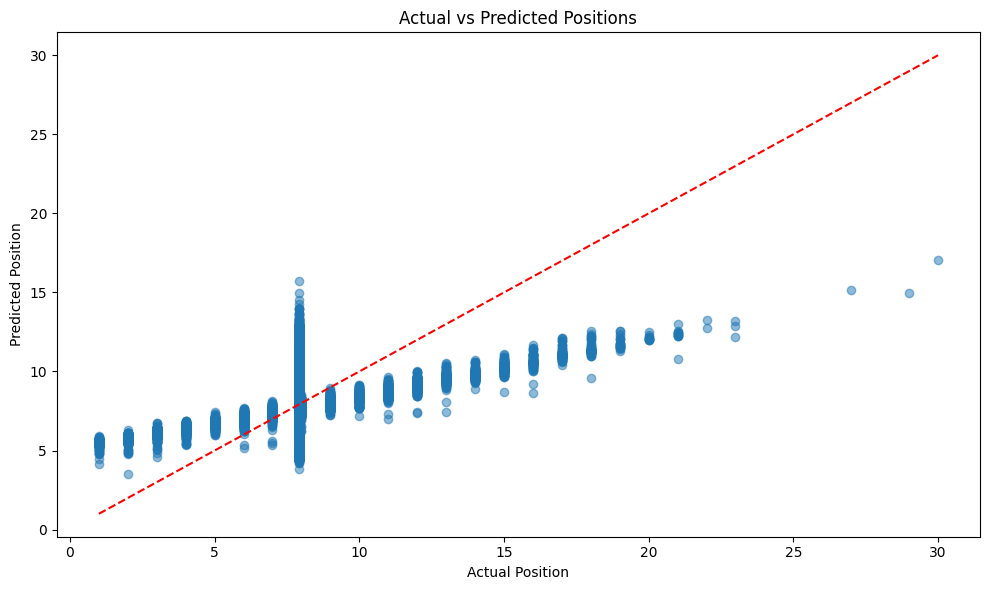

In [0]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
y_train_imputed = imputer.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()
y_test_imputed = imputer.transform(y_test.to_numpy().reshape(-1, 1)).ravel()

# Linear Regression model
with mlflow.start_run(run_name="Linear_Regression_Model") as run:
    # Define hyperparameters
    lr_params = {
        "fit_intercept": True,
        "n_jobs": -1
    }
    
    # Log hyperparameters
    mlflow.log_params(lr_params)
    
    # Create and train the model
    lr_model = LinearRegression(**lr_params)
    lr_model.fit(X_train_imputed, y_train_imputed)
    
    # Make predictions
    y_pred_train = lr_model.predict(X_train_imputed)
    y_pred_test = lr_model.predict(X_test_imputed)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_imputed, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_imputed, y_pred_test)
    r2 = r2_score(y_test_imputed, y_pred_test)
    ev = explained_variance_score(y_test_imputed, y_pred_test)
    
    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log the model
    mlflow.sklearn.log_model(lr_model, "linear_regression_model")
    
    # Create feature importance plot
    plt.figure(figsize=(10, 6))
    plt.bar(features, lr_model.coef_)
    plt.title('Feature Coefficients in Linear Regression Model')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.tight_layout()
    
    # Save and log the plot as an artifact
    coef_plot_path = "lr_coefficients_plot.png"
    plt.savefig(coef_plot_path)
    mlflow.log_artifact(coef_plot_path)
    
    # Create and log a prediction distribution plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_imputed, y_pred_test, alpha=0.5)
    plt.plot([y_test_imputed.min(), y_test_imputed.max()], [y_test_imputed.min(), y_test_imputed.max()], 'r--')
    plt.title('Actual vs Predicted Positions')
    plt.xlabel('Actual Position')
    plt.ylabel('Predicted Position')
    plt.tight_layout()
    
    # Save and log the plot as an artifact
    pred_plot_path = "lr_predictions_plot.png"
    plt.savefig(pred_plot_path)
    mlflow.log_artifact(pred_plot_path)
    
    # Get the run ID for later reference
    lr_run_id = run.info.run_id
    
    # Prepare predictions for database storage - fix the data types
    predictions_df = test_pd[["raceId", "driverId", "position"]].copy()
    predictions_df["predicted_position"] = y_pred_test
    
    # Ensure correct data types
    predictions_df["raceId"] = predictions_df["raceId"].astype(int)
    predictions_df["driverId"] = predictions_df["driverId"].astype(int)
    predictions_df["position"] = predictions_df["position"].fillna(0).astype(int)
    predictions_df["predicted_position"] = predictions_df["predicted_position"].astype(float)
    
    # Add a placeholder column for the missing column in the target table
    predictions_df["placeholder_column"] = 0  # Adjust the default value as needed
    
    # Convert to Spark DataFrame for database insertion
    predictions_spark = spark.createDataFrame(predictions_df)
    
    # Write predictions to the database - use insertInto instead of saveAsTable
    predictions_spark.select(
        col("raceId").cast("int").alias("race_id"),
        col("driverId").cast("int").alias("driver_id"),
        col("predicted_position").cast("float"),
        col("position").cast("int").alias("actual_position"),
        col("placeholder_column").cast("int")  # Ensure the placeholder column is included
    ).write.mode("append").format("delta").insertInto("f1_model1_predictions")
    
    print(f"Linear Regression model metrics: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")



2025/04/27 19:44:15 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.4/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Random Forest model metrics: RMSE=0.2634, MAE=0.0734, R2=0.9952


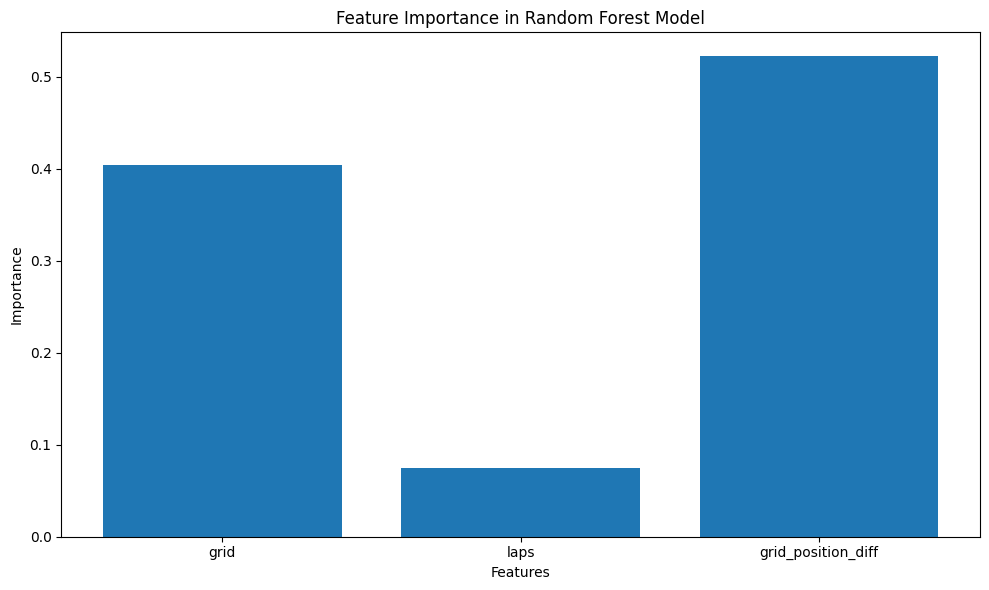

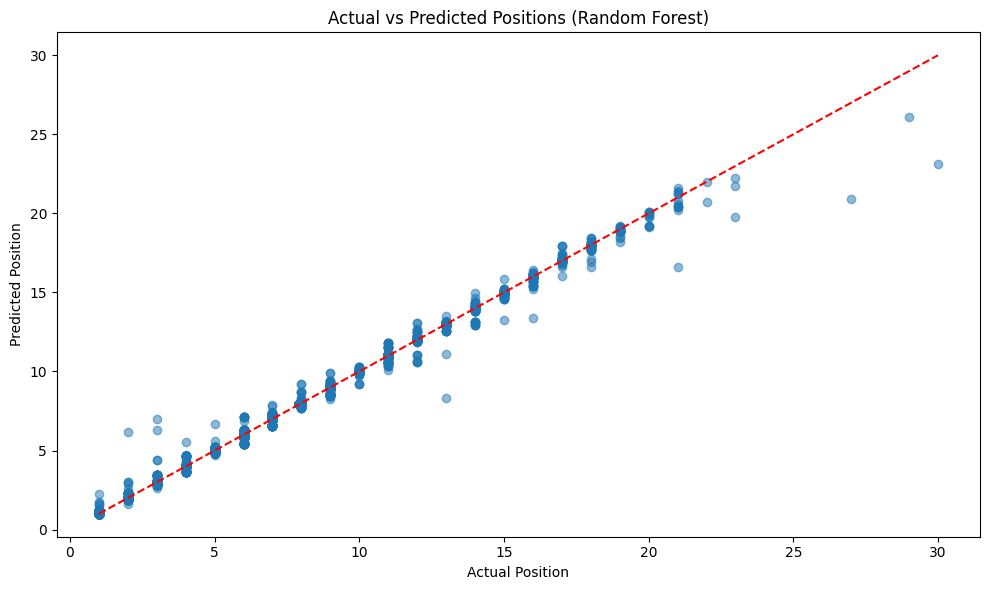

In [0]:
# Random Forest model
with mlflow.start_run(run_name="Random_Forest_Model") as run:
    # Define hyperparameters
    rf_params = {
        "n_estimators": 100,
        "max_depth": 10,
        "min_samples_split": 5,
        "min_samples_leaf": 2,
        "random_state": 42
    }
    
    # Log hyperparameters
    mlflow.log_params(rf_params)
    
    # Create and train the model
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train_imputed, y_train_imputed)
    
    # Make predictions
    y_pred_train = rf_model.predict(X_train_imputed)
    y_pred_test = rf_model.predict(X_test_imputed)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_imputed, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_imputed, y_pred_test)
    r2 = r2_score(y_test_imputed, y_pred_test)
    ev = explained_variance_score(y_test_imputed, y_pred_test)
    
    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # Log the model
    mlflow.sklearn.log_model(rf_model, "random_forest_model")
    
    # Create feature importance plot
    plt.figure(figsize=(10, 6))
    plt.bar(features, rf_model.feature_importances_)
    plt.title('Feature Importance in Random Forest Model')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    
    # Save and log the plot as an artifact
    importance_plot_path = "rf_importance_plot.png"
    plt.savefig(importance_plot_path)
    mlflow.log_artifact(importance_plot_path)
    
    # Create and log a prediction distribution plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_imputed, y_pred_test, alpha=0.5)
    plt.plot([y_test_imputed.min(), y_test_imputed.max()], [y_test_imputed.min(), y_test_imputed.max()], 'r--')
    plt.title('Actual vs Predicted Positions (Random Forest)')
    plt.xlabel('Actual Position')
    plt.ylabel('Predicted Position')
    plt.tight_layout()
    
    # Save and log the plot as an artifact
    pred_plot_path = "rf_predictions_plot.png"
    plt.savefig(pred_plot_path)
    mlflow.log_artifact(pred_plot_path)
    
    # Get the run ID for later reference
    rf_run_id = run.info.run_id
    
    # Prepare predictions for database storage - fix the data types
    predictions_df = test_pd[["raceId", "driverId", "position"]].copy()
    predictions_df["predicted_position"] = y_pred_test
    
    # Ensure correct data types
    predictions_df["raceId"] = predictions_df["raceId"].astype(int)
    predictions_df["driverId"] = predictions_df["driverId"].astype(int)
    predictions_df["position"] = predictions_df["position"].fillna(0).astype(int)
    predictions_df["predicted_position"] = predictions_df["predicted_position"].astype(float)
    
    # Add a placeholder column 
    predictions_df["placeholder_column"] = 0 
    
    # Convert to Spark DataFrame for database insertion
    predictions_spark = spark.createDataFrame(predictions_df)
    
    predictions_spark.select(
        col("raceId").cast("int").alias("race_id"),
        col("driverId").cast("int").alias("driver_id"),
        col("predicted_position").cast("float"),
        col("position").cast("int").alias("actual_position"),
        col("placeholder_column").cast("int")  # Ensure the placeholder column is included
    ).write.mode("append").format("delta").insertInto("f1_model2_predictions")
    
    print(f"Random Forest model metrics: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")


In [0]:
# Verify predictions in the database tables
print("Model 1 Predictions:")
display(spark.sql("SELECT * FROM f1_model1_predictions LIMIT 10"))

print("Model 2 Predictions:")
display(spark.sql("SELECT * FROM f1_model2_predictions LIMIT 10"))

# Get summary statistics for predictions
print("Model 1 Prediction Statistics:")
display(spark.sql("""
    SELECT 
        COUNT(*) as prediction_count,
        AVG(predicted_position) as avg_predicted_position,
        AVG(actual_position) as avg_actual_position,
        AVG(ABS(predicted_position - actual_position)) as avg_absolute_error
    FROM f1_model1_predictions
"""))

print("Model 2 Prediction Statistics:")
display(spark.sql("""
    SELECT 
        COUNT(*) as prediction_count,
        AVG(predicted_position) as avg_predicted_position,
        AVG(actual_position) as avg_actual_position,
        AVG(ABS(predicted_position - actual_position)) as avg_absolute_error
    FROM f1_model2_predictions
"""))


Model 1 Predictions:


race_id,driver_id,predicted_position,actual_position,prediction_date
22,5,9.944339,12,1970-01-01T00:00:00Z
427,118,6.5142837,5,1970-01-01T00:00:00Z
427,84,6.850629,7,1970-01-01T00:00:00Z
427,182,7.4521394,0,1970-01-01T00:00:00Z
427,181,10.39484,0,1970-01-01T00:00:00Z
427,156,12.60378,0,1970-01-01T00:00:00Z
427,160,12.9897995,0,1970-01-01T00:00:00Z
428,95,7.0071435,6,1970-01-01T00:00:00Z
428,179,12.744818,0,1970-01-01T00:00:00Z
428,170,4.6057267,0,1970-01-01T00:00:00Z


Model 2 Predictions:


race_id,driver_id,predicted_position,actual_position,prediction_date
22,5,11.895386,12,1970-01-01T00:00:00Z
427,118,5.0,5,1970-01-01T00:00:00Z
427,84,7.0313797,7,1970-01-01T00:00:00Z
427,182,7.925581,0,1970-01-01T00:00:00Z
427,181,7.925581,0,1970-01-01T00:00:00Z
427,156,7.925581,0,1970-01-01T00:00:00Z
427,160,7.925581,0,1970-01-01T00:00:00Z
428,95,6.0,6,1970-01-01T00:00:00Z
428,179,7.925581,0,1970-01-01T00:00:00Z
428,170,7.925581,0,1970-01-01T00:00:00Z


Model 1 Prediction Statistics:


prediction_count,avg_predicted_position,avg_actual_position,avg_absolute_error
5206,7.977086845655145,4.797733384556281,4.955539306859717


Model 2 Prediction Statistics:


prediction_count,avg_predicted_position,avg_actual_position,avg_absolute_error
10412,8.038886506833162,4.797733384556281,3.3206520989634556
